# HITL - A Learning Bot with Threads

Objective: Using the previous Exercise as a starting point, we modify the bot to enable conversation switching.

We replace the hidden state with a Dropdown Menu that allows the user to select a thread_id (e.g., Thread A, Thread B).

Why? This demonstrates the difference between:

* **Short-term Memory (History):** Information the bot learns only within the current conversation (Thread). If you switch threads, this context is lost.

* **Long-term Knowledge (RAG):** Information retrieved from documents, which is available in all threads.

## 1. Setup & API Keys

In [3]:
# --- 1. SETUP
import os
import gradio as gr
from typing import List, TypedDict, Literal, Annotated
from uuid import uuid4
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver
from tavily import TavilyClient
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from pydantic import BaseModel, Field
from google.colab import drive

# Mount Drive & Keys (Code Prof)
try:
    drive.mount('/content/drive')
    def load_key(path):
        if os.path.exists(path):
            with open(path, 'r', encoding = 'utf-8-sig') as f: return f.read().strip()
        return None
    os.environ['OPENAI_API_KEY'] = load_key('/content/drive/MyDrive/api_key.txt') or input("OpenAI Key: ")
    os.environ['TAVILY_API_KEY'] = load_key('/content/drive/MyDrive/tavily.txt') or input("Tavily Key: ")
except: pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. RAG Initialization

Here we initialize the LLM and index the PDF document into the vector store.

In [4]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Initialize LLM and Embeddings
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

# Setup Vector DB
vector_store = Chroma(embedding_function=embeddings, persist_directory="./chroma_db")

# Index PDF if database is empty
if not vector_store.get()['ids']:
    loader = PyPDFLoader("https://www.jce.ac.il/wp-content/uploads/2025/11/%D7%A0%D7%95%D7%94%D7%9C-%D7%91%D7%97%D7%99%D7%A0%D7%95%D7%AA.pdf")
    docs = loader.load()
    splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=200)
    vector_store.add_documents(documents=splitter.split_documents(docs))
    print("PDF Indexed.")

## 3. Tools Definition
We define the tools (Web Search & PDF Retrieve) and the structured output format.

In [5]:
from langchain_core.tools import tool
from tavily import TavilyClient
from pydantic import BaseModel, Field
from langgraph.prebuilt import ToolNode

# Tool 1: Web Search
@tool
def tavily_search(query: str) -> str:
    """Search the web for current information using Tavily."""
    try:
        client = TavilyClient(api_key=os.environ['TAVILY_API_KEY'])
        return str(client.search(query, max_results=3).get('results', []))
    except: return "No results."

# Tool 2: PDF RAG
@tool
def retrieve(query: str) -> str:
    """Retrieve information related to procedures in Azriely college especially about exams."""
    docs = vector_store.similarity_search(query, k=2)
    return "\n".join([d.page_content for d in docs])

# Structured Output Schema
class FinalResponse(BaseModel):
    """Provide the final answer to the user including a confidence score."""
    answer: str = Field(description="The actual answer to the user's question.")
    confidence: int = Field(description="Confidence score between 1 (low) and 5 (high).")

# Bind tools to LLM
tools = [tavily_search, retrieve, FinalResponse]
tool_node = ToolNode([tavily_search, retrieve])
llm_with_tools = llm.bind_tools(tools)

## 4. LangGraph Logic
This is the core logic: the graph nodes, the human-in-the-loop check, and the routing.

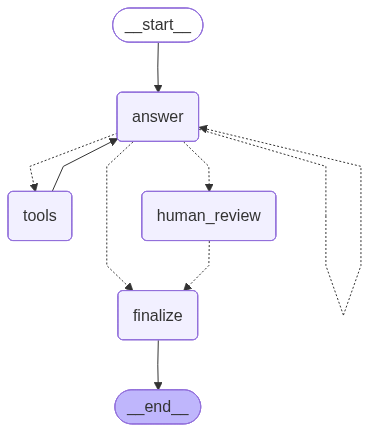

In [6]:
from typing import List, TypedDict, Literal, Annotated
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver

class ChatState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]

# Node: Generate Answer
def answer_node(state: ChatState):
    msgs = state["messages"]
    # Force tool use via System Prompt
    sys_msg = SystemMessage(content="You are a helpful assistant. YOU MUST call the 'FinalResponse' tool to provide both your answer and your confidence level (1-5).")

    # Check if LLM failed to use tool previously
    if isinstance(msgs[-1], AIMessage) and not msgs[-1].tool_calls:
         msgs.append(HumanMessage(content="Error: You answered with plain text. You MUST use the 'FinalResponse' tool."))

    return {"messages": [llm_with_tools.invoke([sys_msg] + msgs)]}

# Node: Human Review (Interrupt)
def human_review_node(state: ChatState) -> Command[Literal["finalize"]]:
    last_message = state["messages"][-1]
    tool_call = last_message.tool_calls[0]

    # Pause execution here
    human_correction = interrupt({
        "current_answer": tool_call["args"].get("answer"),
        "current_confidence": tool_call["args"].get("confidence"),
        "tool_call_id": tool_call["id"]
    })

    # Update with correction
    updated_tool_call = {
        "name": "FinalResponse",
        "args": {"answer": human_correction["answer"], "confidence": 5},
        "id": tool_call["id"], "type": "tool_call"
    }

    # Update message in history
    new_message = last_message.model_copy(update={"tool_calls": [updated_tool_call]})
    if hasattr(last_message, "id"): new_message.id = last_message.id

    return Command(update={"messages": new_message}, goto="finalize")

# Node: Finalize
def finalize_node(state: ChatState):
    last_message = state["messages"][-1]
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        tool_call = last_message.tool_calls[0]
        return {"messages": [ToolMessage(tool_call_id=tool_call["id"], content="Response delivered.", name=tool_call["name"])]}
    return {"messages": []}

# Router Logic
def should_continue(state: ChatState):
    last_message = state["messages"][-1]
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        if last_message.tool_calls[0]['name'] == 'FinalResponse':
            # Check confidence
            if last_message.tool_calls[0]['args'].get('confidence', 5) <= 4: return "human_review"
            else: return "finalize"
        return "tools"
    return "answer"

# Build Graph
builder = StateGraph(ChatState)
builder.add_node("answer", answer_node)
builder.add_node("tools", tool_node)
builder.add_node("human_review", human_review_node)
builder.add_node("finalize", finalize_node)

builder.add_edge(START, "answer")
builder.add_conditional_edges("answer", should_continue, ["tools", "human_review", "finalize", "answer"])
builder.add_edge("tools", "answer")
builder.add_edge("human_review", "finalize")
builder.add_edge("finalize", END)

graph = builder.compile(checkpointer = MemorySaver())
graph

## 5. Helper Functions for UI
Functions to handle chat execution and load history per thread (Exercise 10 Requirement).

In [7]:
import gradio as gr

# Exercise 10: Load history specific to the selected Thread ID
def load_thread_history(thread_id):
    """Fetches history from graph state formatted as dictionaries."""
    config = {"configurable": {"thread_id": thread_id}}
    state = graph.get_state(config)
    history = []

    if state.values:
        msgs = state.values.get("messages", [])
        current_user = None
        for msg in msgs:
            if isinstance(msg, HumanMessage):
                current_user = msg.content
                history.append({"role": "user", "content": str(current_user)})
            elif isinstance(msg, AIMessage) and current_user:
                txt = msg.content
                if msg.tool_calls and msg.tool_calls[0]["name"] == "FinalResponse":
                    txt = msg.tool_calls[0]["args"].get("answer")
                if txt:
                    history.append({"role": "assistant", "content": str(txt)})
    return history

# Run Chat Logic
def run_chat(user_text, history, thread_id, pending_question):
    if history is None: history = []
    if not user_text: return "", history, thread_id, pending_question, "N/A", gr.update(visible=False), gr.update(), gr.update()

    # Append user message immediately
    current_history = history + [{"role": "user", "content": user_text}]
    cfg = {"configurable": {"thread_id": thread_id}}

    try:
        result = graph.invoke({"messages": [HumanMessage(content=user_text)]}, config=cfg)
    except Exception as e:
        return "", current_history, thread_id, user_text, f"Error: {e}", gr.update(visible=False), gr.update(), gr.update()

    # Check for Interrupts (Low Confidence)
    snapshot = graph.get_state(cfg)
    if snapshot.tasks and snapshot.tasks[0].interrupts:
        int_val = snapshot.tasks[0].interrupts[0].value
        draft = int_val.get("current_answer", "")
        draft_conf = int_val.get("current_confidence", 0)

        status = f" PAUSED: Low Confidence ({draft_conf}/5)"
        context = f"**User Asked:** {user_text}\n\n**AI Drafted:** {draft}"

        return "", current_history, thread_id, user_text, status, gr.update(visible=True), gr.update(value=context), gr.update(value=draft)

    return process_final_result(result, current_history, thread_id, user_text)

# Helper to format result
def process_final_result(result, history, thread_id, user_text):
    ai_text = "Error: No answer found."
    conf = "N/A"

    for msg in reversed(result["messages"]):
        if isinstance(msg, AIMessage) and hasattr(msg, 'tool_calls') and msg.tool_calls:
             if msg.tool_calls[0]["name"] == "FinalResponse":
                args = msg.tool_calls[0]["args"]
                ai_text = args.get("answer", "")
                conf = str(args.get("confidence", "N/A"))
                break

    # Update history with AI response
    if history and history[-1]['role'] == 'user':
        new_history = history + [{"role": "assistant", "content": ai_text}]
    else:
        new_history = history + [{"role": "user", "content": user_text}, {"role": "assistant", "content": ai_text}]

    return "", new_history, thread_id, None, f"Done ({conf}/5)", gr.update(visible=False), gr.update(), gr.update()

# Admin Submission Logic
def submit_admin_review(correction, thread_id, history, pending_question):
    cfg = {"configurable": {"thread_id": thread_id}}
    result = graph.invoke(Command(resume={"answer": correction}), config=cfg)
    return process_final_result(result, history, thread_id, pending_question)

## 6. Gradio UI (Adding Thread_ID)
Here is the modified UI. We added a Dropdown to switch threads and linked it to load_thread_history.

In [8]:
with gr.Blocks(title="HITL Agent - Exercise 10") as demo:
    gr.Markdown("# LangGraph Agent — HITL with Thread Switching (Exercise 10)")


    # Replaced hidden State with visible Dropdown
    thread_picker = gr.Dropdown(
        choices=["Thread_Alpha", "Thread_Beta", "Thread_Gamma"],
        value="Thread_Alpha",
        label="Select Conversation Thread"
    )

    pending_question_state = gr.State(value=None)

    # Chat Interface
    chatbot = gr.Chatbot(height=400)
    status_label = gr.Label(value="Ready", label="System Status")

    with gr.Row():
        txt = gr.Textbox(placeholder="User: Ask a question...", scale=4)
        send = gr.Button("Send", variant="primary")

    # Admin Panel (Hidden)
    with gr.Group(visible=False) as admin_panel:
        gr.Markdown("### 👮 Admin Review Required")
        admin_context = gr.Markdown("Waiting for context...")
        admin_input = gr.Textbox(label="Edit the Answer:", lines=3)
        approve_btn = gr.Button("Approve / Submit Correction", variant="stop")

    # --- EVENTS ---

    # 1. Thread Switching: Load specific history
    thread_picker.change(
        fn=load_thread_history,
        inputs=[thread_picker],
        outputs=[chatbot]
    )

    # 2. Send Message
    send.click(
        run_chat,
        inputs=[txt, chatbot, thread_picker, pending_question_state],
        outputs=[txt, chatbot, thread_picker, pending_question_state, status_label, admin_panel, admin_context, admin_input]
    )

    # 3. Submit Correction
    approve_btn.click(
        submit_admin_review,
        inputs=[admin_input, thread_picker, chatbot, pending_question_state],
        outputs=[txt, chatbot, thread_picker, pending_question_state, status_label, admin_panel, admin_context, admin_input]
    )

if __name__ == "__main__":
    demo.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://9d28d81bed07105e74.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://9d28d81bed07105e74.gradio.live
